### LT2316 (HT 2021) - Assignment 1
#### Calvin Kullvén-Liao

In [1]:
import json

### Available data & structure

In [2]:
# Get the available image files on the server
from os import walk
image_files_on_server = next(walk('/scratch/lt2326-h21/a1/images/'), (None, None, []))[2]
len(image_files_on_server)

1000

In [3]:
# Load data and filter=> only those that correspond to the 1000 images on server
jsonl_filenames = ['train', 'val', 'test_cls'] # 24290+1597+3269 = 29156 annotated photos

data_entries = []
for fn in jsonl_filenames:
    with open(f'/scratch/lt2326-h21/a1/{fn}.jsonl') as f:
        entries = [json.loads(x) for x in f if (json.loads(x)['file_name'] in image_files_on_server)]
        data_entries.extend(entries)
        
len(data_entries)

1000

In [4]:
# format of each entry in the data:
#  {'annotations':[list of annos], 'file_name':str, 'height':int, 'ignore':[boxes], 'image_id':str, 'width':int}
#      /each anno: [list of char-dicts]
#        /each dict reps a character: {'adjusted_bbox', 'attributes', 'is_chinese', 'polygon', 'text'}
#          'adjusted_bbox':[x,y,w,h] where x,y is the btm-left point 
#          'attributes':[str] eg, ['distorted', 'raised']
#          'is_chinese':Bool
#          'polygon': list of 4 coordinates [[x,y],[x,y],[x,y],[x,y]]
#          'text':str of Chinese char

data_entries[0]

{'annotations': [[{'adjusted_bbox': [140.26028096262758,
     897.1957001682758,
     22.167573140645146,
     38.36424196832945],
    'attributes': ['distorted', 'raised'],
    'is_chinese': True,
    'polygon': [[140.26028096262758, 896.7550603352049],
     [162.42785410327272, 898.0769798344178],
     [162.42785410327272, 935.7929346470926],
     [140.26028096262758, 935.0939571156308]],
    'text': '明'},
   {'adjusted_bbox': [162.42785410327272,
     898.5416545674744,
     23.376713493771263,
     37.74268246537315],
    'attributes': ['distorted', 'raised'],
    'is_chinese': True,
    'polygon': [[162.42785410327272, 898.0769798344178],
     [185.80456759704398, 899.4710040335876],
     [185.80456759704398, 936.5300382257251],
     [162.42785410327272, 935.7929346470926]],
    'text': '海'},
   {'adjusted_bbox': [185.80456759704398,
     899.90363223333,
     21.764526356269812,
     37.08391855844286],
    'attributes': ['distorted', 'raised'],
    'is_chinese': True,
    'polyg

In [5]:
import matplotlib.pyplot as plt # Show np-array as image
import matplotlib.image as mpimg # Load/read jpg as np-array
import matplotlib.patches as patches # Draw rectagles
import rasterio.features
from shapely.geometry.polygon import Polygon

def show_entry_details(entry):
    annotations, image_fn = entry['annotations'], entry['file_name']
    print('Filename:', image_fn)
    if image_fn not in image_files_on_server:
        print("Image file not on MLTGPU server")
        return
    
    polygons = []
    for anno in annotations:
        chars = []
        for char in anno:
            if char['is_chinese']:
                text, polygon = char['text'], char['polygon']
                chars.append(text)
                polygons.append(polygon)
            
        print(chars)

    print('No of boxes/characters:',len(polygons)) # boxes for characters
    
    img_file = '/scratch/lt2326-h21/a1/images/'+image_fn
    img_nparray = mpimg.imread(img_file) #a np-array of (2048,2048,3) ie, (w,h,RGB) 

    # Create figure & axes, and display the image
    plt.figure(figsize=(10, 10))
    axes = plt.gca()
    axes.imshow(img_nparray)
    
    # Superimpose polygonal boxes onto the image        
    for a_polygon in polygons: # a_polygon = [[x,y],[x,y],[x,y],[x,y]]
        # Create polygon
        polygon_box = patches.Polygon(a_polygon,
                                     linewidth=0.8, edgecolor='r', facecolor='none')
        # Add the rectangle to the Axes
        axes.add_patch(polygon_box)
    
    # Show the image and the boxes
    plt.show()
    
    # Show the mask where yellow=1, purple=0, corresponding to whether a pixel is in a box 
    w, h = img_nparray.shape[:2]
    Polygon_objects=[]
    for a_polygon in polygons:
        Polygon_objects.append(Polygon(a_polygon))
    mask_array = rasterio.features.rasterize(Polygon_objects, out_shape=(w,h))
    print(mask_array.shape) # (2048,2048,1) 
    plt.imshow(mask_array)

Filename: 1001821.jpg
['我', '衣']
['北', '京', '君', '太', '百', '货']
['北', '京', '君', '太', '百', '货']
['我', '衣', '我', '心']
No of boxes/characters: 18


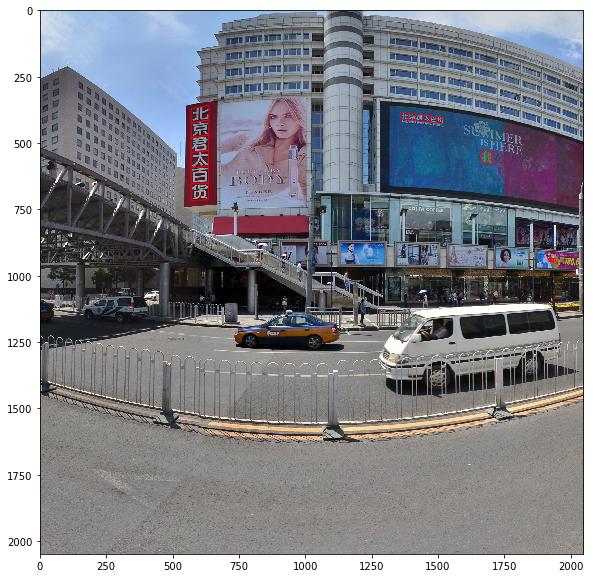

(2048, 2048)


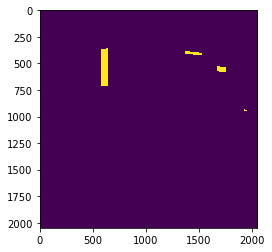

In [6]:
# Example of an entry's image file, the characters of annotations, and the boxes on image
an_entry = data_entries[666]
show_entry_details(an_entry)


### Load X, Y data & split to train/test

In [7]:
from skimage.transform import resize
def entry_to_arrays(entry, downsize=(256,256)):
    '''Reads an data entry and returns its image_array and mask_array '''
    annotations, image_fn = entry['annotations'], entry['file_name']
    
    # List of all polygons
    Polygon_objects=[]
    for anno in annotations:
        for char in anno:
            polygon = char['polygon']
            Polygon_objects.append(Polygon(polygon))
    
    # Path of jpg files on MLTGPU server: ~/scratch/lt2326-h21/a1/images
    img_file = '/scratch/lt2326-h21/a1/images/'+image_fn
    
    # The features = the image itself
    img_array = mpimg.imread(img_file) #a np-array of (2048,2048,3) ie, (w,h,RGB) 
    w, h = img_array.shape[:2]
    downsized_array = resize(img_array, downsize)

    # The labels = the mask of whether a pixel is in a box 
    mask_array = rasterio.features.rasterize(Polygon_objects, out_shape=(w,h))
    
    return downsized_array, mask_array

img_array, mask_array = entry_to_arrays(data_entries[999])
img_array.shape, mask_array.shape

((256, 256, 3), (2048, 2048))

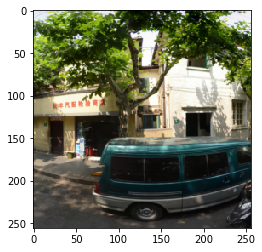

In [8]:
plt.imshow(img_array)

In [9]:
xy_pairs = list(entry_to_arrays(entry) for entry in data_entries[:100])
import pandas as pd
df = pd.DataFrame(xy_pairs, columns=['image_features', 'mask_labels'])
df

,image_features,mask_labels
0,"[[[0.8627450980392157, 0.9529411764705882, 0.9...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,"[[[0.8666666666666667, 0.9411764705882353, 0.9...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,"[[[0.8215686274509812, 0.9274509803921578, 0.9...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,"[[[0.38823529411764707, 0.41176470588235115, 0...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,"[[[0.4666666666666667, 0.6, 0.8166666666666671...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...
95,"[[[0.4568627450980401, 0.6235294117647059, 0.9...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
96,"[[[0.32156862745098036, 0.4784313725490196, 0....","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
97,"[[[0.8333333333333377, 0.8529411764705919, 0.8...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
98,"[[[0.883333333333332, 0.8882352941176461, 0.87...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [10]:
import numpy as np

#Unzip to [arrays of imgs/features],  [arrays of masks/labels]
X, Y = zip(*xy_pairs)
X, Y = np.array(X), np.array(Y)
X.shape, Y.shape # 1000 images; 1000 masks

((100, 256, 256, 3), (100, 2048, 2048))

In [13]:
# split to train:test by 85:15
cut = 850
train_X, train_Y = X[:cut], Y[:cut]
test_X, test_Y = X[cut:], Y[cut:]

train_X.shape, train_Y.shape, test_X.shape, test_Y.shape # 850 images & 850 masks; 150 images & 150 masks

((85, 256, 256, 3), (85, 2048, 2048), (15, 256, 256, 3), (15, 2048, 2048))

In [11]:
# split to train:test by 85:15
minicut = 85 
mini_train_X, mini_train_Y = X[:minicut], Y[:minicut]
mini_test_X, mini_test_Y = X[minicut:100], Y[minicut:100]

mini_train_X.shape, mini_train_Y.shape, mini_test_X.shape, mini_test_Y.shape 
# 85 images & 85 masks; 15 images & 15 masks

((85, 256, 256, 3), (85, 2048, 2048), (15, 256, 256, 3), (15, 2048, 2048))

### Convert data to tensors, generate batches, and train PyTorch model

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
   

# Turn arrays to tensors
cpu = torch.device('cpu')
gpu = torch.device('cuda:1')
train_X_tensor = torch.Tensor(train_X).to(cpu)
train_Y_tensor = torch.Tensor(train_Y).to(cpu) # Y seems to be too large for GPU memory
test_X_tensor = torch.Tensor(test_X).to(cpu)
test_Y_tensor = torch.Tensor(test_Y).to(cpu)


In [15]:
# Generate shuffled batches
class Batcher:
    def __init__(self, X, Y, device, batch_size=50, max_iter=None):
        self.X, self.Y, self.device, self.batch_size, self.max_iter = X, Y, device, batch_size, max_iter
        self.curr_iter = 0 # initialized to 0
    
    def __iter__(self):
        return self
    
    #Upon each iteration
    def __next__(self):
        if self.curr_iter == self.max_iter:
            raise StopIteration
        
        # Shuffle X,Y and split the shuffled X,Y
        
        # create indeces permutation
        shuffled_indices = torch.randperm(self.X.shape[0], device=self.device) 
#         shuffled_i_cpu = shuffled_indices.to('cpu')
        # reorder X,Y with the permutation indeces; keep Y on CPU
        shuffled_X, shuffled_Y = self.X[shuffled_indices], self.Y[shuffled_indices]
        
        # Generate smaller chunks of X,Y of batch size
        split_X = torch.split(shuffled_X, self.batch_size)
        split_Y = torch.split(shuffled_Y, self.batch_size)
        
        self.curr_iter += 1
        
        return zip(split_X, split_Y) # batchsize of (X,Y) pairs ie, (features, label)
  

In [30]:
class ModelCNN(nn.Module):
    def __init__(self, hidden_channels=32):
        super(ModelCNN, self).__init__() # inherit nn.Module
#         self.device = device
        self.hc = hidden_channels 
        
        # Bx3x100x100 => Bx32x100x100
        self.layers_1 = nn.Sequential(
            nn.Conv2d(3,self.hc,(3,3), stride=1, padding=(1,1)), 
                    # in_chan, out_chan, 3*3 window, 
            nn.ReLU(), nn.Tanh(),
        )
        
        # Bx32x100x100 => Bx64x200x200
        self.layers_2 = nn.Sequential(
            nn.Upsample((200,200)),
            nn.Dropout(0.2),
            nn.Conv2d(self.hc,2*self.hc,(3,3), stride=1, padding=(1,1)), 
            nn.ReLU(), nn.Tanh(),
        )
        
        # Bx32x200x200 => Bx1x2048x2048
        self.layers_3 = nn.Sequential(
            nn.Upsample((2048,2048)),
            nn.Conv2d(2*self.hc,self.hc,(3,3), stride=1, padding=(1,1)),
            nn.ReLU(), nn.Tanh(),
            nn.Conv2d(self.hc,1,(3,3), stride=1, padding=(1,1)),
            nn.Sigmoid(),
        )
        
        
    def forward(self, batch):
        # original tensor: B x W x H x 3
        current_matrix = batch.permute(0,3,1,2) # Move channel dim to front =>B x 3 x W x H
        
        #L1:
        current_matrix = self.layers_1(current_matrix) # B x hc x W x H
        
        #L2:
        current_matrix = self.layers_2(current_matrix) # =>B x 2hc x 200 x 200

        #L3
        current_matrix = self.layers_3(current_matrix)  # =>B x 1 x 2048 x 2048
        
        out = current_matrix.permute(0,2,3,1) # output:  Bx2048x2048x1
        
        return out

In [36]:
def train_model(X, Y, batch_size, epochs, device, model, model_filename):
    '''Trains a model with batched X,Y data'''
    
    b = Batcher(X, Y, device=device, batch_size=batch_size, max_iter=epochs)
    
    # train a new model or continue training an existing model
    m = model.to(device)
        
    criterion = nn.BCELoss()
    optimizer = optim.Adam(m.parameters(), lr=0.005)
    epoch=1
    
    # Loop of each epoch
    for batching in b:
        total_loss = 0
        count = 1
        for batch in batching:
            optimizer.zero_grad()
            features, label = batch[0], batch[1]

            # Put tensors (only from a batch) on GPU
#             features, label = features.to(device), label.to(device)

            out = m(features) #model predictions

            #Flatten output and labels so they can be compared
            loss = criterion(out.reshape(-1), label.reshape(-1)) # out=BxWxHx64; label=BxWxH
            total_loss += loss.item()
            count += 1

            # Learn/optimize the model from the loss
            loss.backward()
            optimizer.step()

            # Delete batch tensors on GPU to release memory
#             del features
#             del label
#             torch.cuda.empty_cache()

            print(f'Epoch {epoch}  Avg loss: {total_loss/count}  Processed data: {count}', end='\r')
            # Save the trained-so-far model
            torch.save(m.state_dict(), model_filename)
            
        print()
        epoch+=1

    
    return m # returns trained model

In [25]:
test_b = Batcher(train_X_tensor, train_Y_tensor, device=gpu, batch_size=10, max_iter=10)

In [26]:
split_chunk = next(test_b) # genObj / chunks / batches_of_pairs
a_x, a_y = list(split_chunk)[0]
a_x.shape, a_y.shape

(torch.Size([10, 100, 100, 3]), torch.Size([10, 2048, 2048]))

In [46]:
test_m = ModelCNN( height=100, width=100).to(gpu)
# del test_m

In [47]:
test_out = test_m(a_x)
test_out.shape

RuntimeError: CUDA out of memory. Tried to allocate 10.00 GiB (GPU 1; 10.92 GiB total capacity; 1.02 GiB already allocated; 8.98 GiB free; 1.11 GiB reserved in total by PyTorch)

In [89]:
# gpu = torch.device('cuda:0')

In [37]:
init_model = ModelCNN()
cnn_model = train_model(train_X_tensor, train_Y_tensor, 
                       batch_size=10, epochs=20, device=cpu, 
                       model=init_model, model_filename='cnn_model')

Epoch 1  Avg loss: 0.13672745013609527  Processed data: 10
Epoch 2  Avg loss: 0.02831926764920354  Processed data: 10
Epoch 3  Avg loss: 0.03132569957524538  Processed data: 10
Epoch 4  Avg loss: 0.02936323285102844  Processed data: 10
Epoch 5  Avg loss: 0.026735908444970848  Processed data: 10
Epoch 6  Avg loss: 0.026687261834740638  Processed data: 10
Epoch 7  Avg loss: 0.02578354552388191  Processed data: 10
Epoch 8  Avg loss: 0.0249975617043674  Processed data: 109
Epoch 9  Avg loss: 0.02518213726580143  Processed data: 10
Epoch 10  Avg loss: 0.02665083948522806  Processed data: 10
Epoch 11  Avg loss: 0.02685287930071354  Processed data: 10
Epoch 12  Avg loss: 0.026133231073617934  Processed data: 10
Epoch 13  Avg loss: 0.026043356768786906  Processed data: 10
Epoch 14  Avg loss: 0.027354003116488456  Processed data: 10
Epoch 15  Avg loss: 0.02515403348952532  Processed data: 10
Epoch 16  Avg loss: 0.026103355921804905  Processed data: 10
Epoch 17  Avg loss: 0.027386084757745267  P

In [18]:
# Load saved model
cnn_model = ModelCNN(hidden_size=1024, height=128, width=128)
cnn_model.load_state_dict(torch.load('cnn_classify'))
cnn_model.eval()


torch.Size([1, 2048, 2048])

In [38]:
with torch.no_grad():
    test_out = cnn_model(train_X_tensor[:10])
test_out.shape

torch.Size([10, 2048, 2048, 1])

In [39]:
test_out[0].shape

torch.Size([2048, 2048, 1])

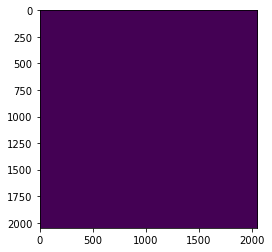

In [42]:
test_array = test_out[9].detach().numpy()
test_array = test_array.reshape(2048,2048)
plt.imshow(test_array)

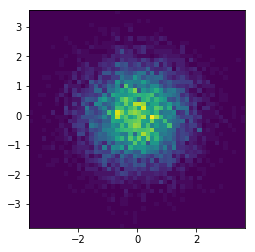

In [52]:
# Generate some test data
x = np.random.randn(8873)
y = np.random.randn(8873)

heatmap, xedges, yedges = np.histogram2d(x, y, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

In [49]:
y

array([ 1.46156645, -0.70416421,  0.8620207 , ...,  0.30697232,
        1.90564489, -1.6118445 ])

In [44]:
torch.cuda.memory_summary(device=gpu, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 1                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 2            |        cudaMalloc retries: 2         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  777416 KB |     856 MB |    1786 MB |    1026 MB |\n|       from large pool |  777112 KB |     856 MB |    1785 MB |    1026 MB |\n|       from small pool |     304 KB |       0 MB |       0 MB |       0 MB |\n|---------------------------------------------------------------------------|\n| Active memory         |  777416 KB |     856 MB |    1786 MB |    1026 MB |\n|       from large pool |  777112 KB |     856 MB |

In [ ]:
# TODO
# adjust the contrast, colours etc and add to the training set,
# so the model can recognised characters in different lightings
# OCR of Chinese characters: vectorize them to combination of '8 strokes'